In [1]:
import tensorflow as tf
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-qr5jgn25
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-qr5jgn25
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=173744 sha256=dc425430413eb0365f1285988deaf44ad22f05fc4c27f85913af36fb339044a8
  Stored in directory: /tmp/pip-ephem-wheel-cache-rtkvr0jx/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [67]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [68]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [69]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  

In [70]:
np.shape(train_images[1]), np.shape(train_labels[1])

((28, 28, 1), ())

In [71]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [91]:
idx = np.random.permutation(len(train_images))
x,y = train_images[idx], train_labels[idx]

train_dataset = tf.data.Dataset.from_tensor_slices(x[:-96]).batch(BATCH_SIZE)
label_dataset = tf.data.Dataset.from_tensor_slices(y[:-96]).batch(BATCH_SIZE)


#train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
#label_dataset = tf.data.Dataset.from_tensor_slices(train_labels).batch(BATCH_SIZE)

# Architecture
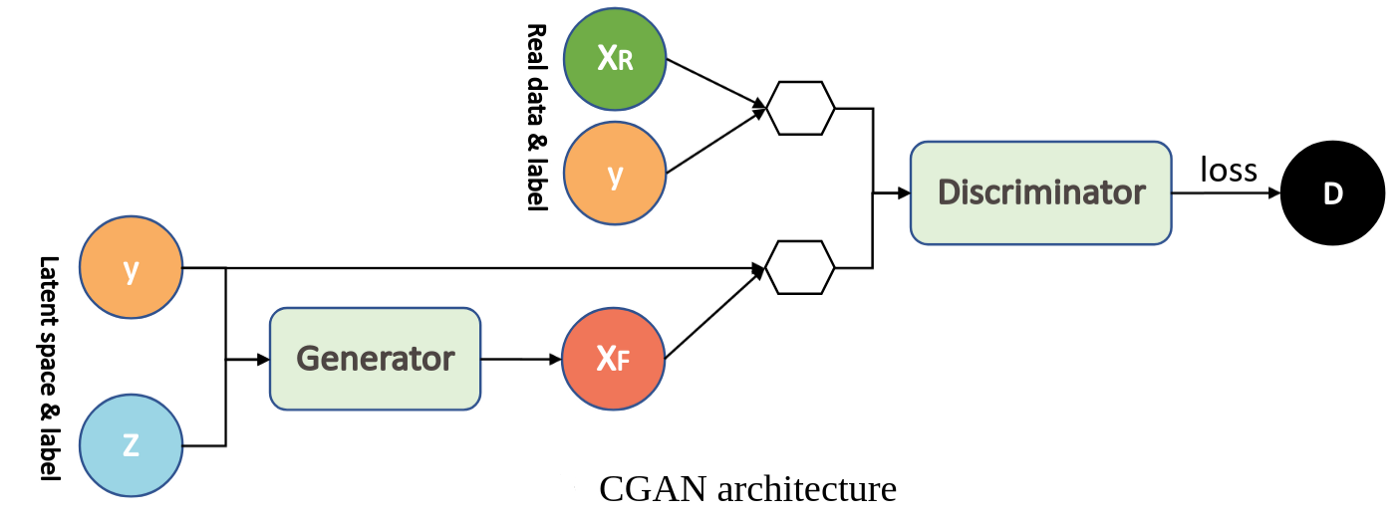

In [73]:
def make_generator_model():
    ################################################################################
    # model = tf.keras.Sequential()
    # model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    # model.add(layers.BatchNormalization())
    # model.add(layers.LeakyReLU())

    # model.add(layers.Reshape((7, 7, 256)))
    # assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    # model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    # assert model.output_shape == (None, 7, 7, 128)
    # model.add(layers.BatchNormalization())
    # model.add(layers.LeakyReLU())

    # model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    # assert model.output_shape == (None, 14, 14, 64)
    # model.add(layers.BatchNormalization())
    # model.add(layers.LeakyReLU())

    # model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    # assert model.output_shape == (None, 28, 28, 1)
    ################################################################################

    # label input
	in_label = layers.Input(shape=(1,), name='label')
	# embedding for categorical input
	li = layers.Embedding(10, 10)(in_label)
	# linear multiplication
	n_nodes = 7 * 7
	li = layers.Dense(n_nodes)(li)
	# reshape to additional channel
	li = layers.Reshape((7, 7, 1))(li)
    
    
	# image generator input
	in_lat = layers.Input(shape=(100,),name='noise')
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	gen = layers.Dense(n_nodes)(in_lat)
	gen = layers.LeakyReLU(alpha=0.2)(gen)
	gen = layers.Reshape((7, 7, 128))(gen)
    
    
	# merge image gen and label input
	merge = layers.Concatenate()([gen, li])
    
    
	# upsample to 14x14
	gen = layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
	gen = layers.LeakyReLU(alpha=0.2)(gen)
	# upsample to 28x28
	gen = layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
	gen = layers.LeakyReLU(alpha=0.2)(gen)
	# output
	out_layer = layers.Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
	# define model
	model = tf.keras.Model([in_lat, in_label], out_layer)
    
	return model

In [74]:
generator = make_generator_model()
generator.summary()
#noise = tf.random.normal([1, 100])
#generated_image = generator(noise, training=False,)

#plt.imshow(generated_image[0, :, :, 0], cmap='gray')

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 noise (InputLayer)             [(None, 100)]        0           []                               
                                                                                                  
 label (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 dense_21 (Dense)               (None, 6272)         633472      ['noise[0][0]']                  
                                                                                                  
 embedding_10 (Embedding)       (None, 1, 10)        100         ['label[0][0]']                  
                                                                                           

In [75]:
def make_discriminator_model():
    ################################################################################
    # model = tf.keras.Sequential()
    # model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
    #                                  input_shape=[28, 28, 1]))
    # model.add(layers.LeakyReLU())
    # model.add(layers.Dropout(0.3))

    # model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    # model.add(layers.LeakyReLU())
    # model.add(layers.Dropout(0.3))

    # model.add(layers.Flatten())
    # model.add(layers.Dense(1))
    ################################################################################
    in_shape=(28,28,1)
    in_label = layers.Input(shape=(1,), name='label') # label input
    li = layers.Embedding(10, 10)(in_label) # embedding for categorical input 
    n_nodes = in_shape[0] * in_shape[1] # scale up to image dimensions with linear activation

    li = layers.Dense(n_nodes)(li) 
    li = layers.Reshape((in_shape[0], in_shape[1], 1))(li) # reshape to additional channel

    in_image = layers.Input(shape=in_shape, name='image') # image input

    merge = layers.Concatenate()([in_image, li]) # concat label as a channel

    fe = layers.Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
    fe = layers.LeakyReLU(alpha=0.2)(fe)

    fe = layers.Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
    fe = layers.LeakyReLU(alpha=0.2)(fe)

    fe = layers.Flatten()(fe)

    fe = layers.Dropout(0.4)(fe)

    out_layer = layers.Dense(1, activation='sigmoid')(fe)

    # define model
    model = tf.keras.Model([in_image, in_label], out_layer)
    return model

In [76]:
discriminator = make_discriminator_model()
discriminator.summary()
#decision = discriminator(generated_image)
#print (decision)

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 label (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 embedding_11 (Embedding)       (None, 1, 10)        100         ['label[0][0]']                  
                                                                                                  
 dense_22 (Dense)               (None, 1, 784)       8624        ['embedding_11[0][0]']           
                                                                                                  
 image (InputLayer)             [(None, 28, 28, 1)]  0           []                               
                                                                                           

In [77]:
lbl = np.array([6])
noise = tf.random.normal([1,100])
test = generator({'label':lbl, 'noise':noise}, training=False)
yo = discriminator({'label':lbl, 'image':test}, training=False)
yo

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.49958563]], dtype=float32)>

In [78]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [79]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [80]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [81]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [82]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [83]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [84]:
################################################################################
# @tf.function
# def train_step(images):
#     noise = tf.random.normal([BATCH_SIZE, noise_dim])

#     with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
#       generated_images = generator(noise, training=True)

#       real_output = discriminator(images, training=True)
#       fake_output = discriminator(generated_images, training=True)

#       gen_loss = generator_loss(fake_output)
#       disc_loss = discriminator_loss(real_output, fake_output)

#     gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
#     gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

#     generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
#     discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
################################################################################
@tf.function # compile function
def train_step(image_batch, label_batch):
    noise = tf.random.normal([BATCH_SIZE, 100])
    #fake_labels = tf.random.uniform(shape=(BATCH_SIZE,1), minval=0, maxval=9, dtype=tf.int32)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator({'label':label_batch, 'noise':noise}, training=True)
        
        real_output = discriminator({'label':label_batch, 'image':image_batch}, training=True)
        
        fake_output = discriminator({'label':label_batch, 'image':generated_images}, training=True)
        
        # CALCULATE LOSS OF FAKE AND REAL IMAGES
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
    # get gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    # 
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [85]:
train_dataset

<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>

In [86]:
np.size(label_dataset)

1

In [87]:
seed = tf.random.normal([10, 100])
seed_label = np.array([0,1,2,3,4,5,6,7,8,9])

In [88]:
def train(train_dataset,label_dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    #for image_batch in dataset:
    for image_batch, label_batch in zip(train_dataset, label_dataset):
      train_step(image_batch,label_batch)

    display.clear_output(wait=True)
    generate_and_save_images(generator,epoch + 1,seed)

    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  display.clear_output(wait=True)
  generate_and_save_images(generator,epochs,seed)

In [89]:
def generate_and_save_images(model, epoch, test_input):
  predictions = generator({'label':seed_label, 'noise':seed}, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

(-0.5, 235.5, 174.5, -0.5)

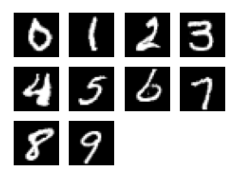

In [94]:
train(train_dataset,label_dataset, EPOCHS)

at the end save the generator model upload in lms

In [95]:
generator.save('generator.h5')